In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x

In [2]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
# importlib.reload(xr)
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gsw
from os.path import exists
from datetime import datetime

In [3]:
def remove_daily_climatology(ds):
    ds = ds.convert_calendar('noleap')
    ds_climatology = ds.groupby("time.dayofyear").mean("time")
    #compute monthly anomalies 
    anomalies = ds.groupby("time.dayofyear") - ds_climatology
    anomalies = anomalies.drop("dayofyear") 
    reindex_datetimes = [datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S') for date in anomalies.time.values]
    anomalies["time"] = reindex_datetimes
    return anomalies
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")

In [4]:
GLORYS_dir = r"/vortexfs1/share/cdx/hseo/Data/MERCATOR/NEP_daily" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

In [5]:
ds = xr.open_dataset(GLORYS_data_dir("GLORYS_SoCalLine90.nc")).mean("distance")
ds_line = xr.open_dataset(GLORYS_data_dir("GLORYS_SoCalLine90.nc"))

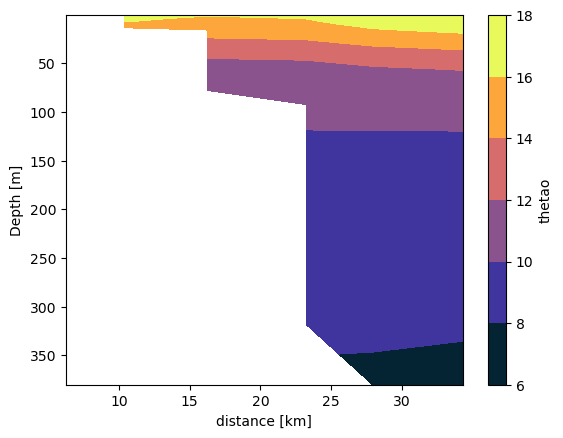

In [19]:
theta_TS = ds.thetao;
salinity_TS = ds.so;

In [35]:
import gsw

def sigma0_from_SP_and_pt0(z, SP, pt0, lon = 0, lat = 30):
    p = gsw.p_from_z(-abs(z), lat)
    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_pt(SA,pt0)
    sigma0 = gsw.sigma0(SA,CT)
    return sigma0

In [42]:
z = -ds_line.depth
SP = ds_line.so
pt0 = ds_line.thetao
sigma0_TS_line = sigma0_from_SP_and_pt0(z, SP, pt0)
sigma0_TS_line = sigma0_TS_line.rename("sigma0")

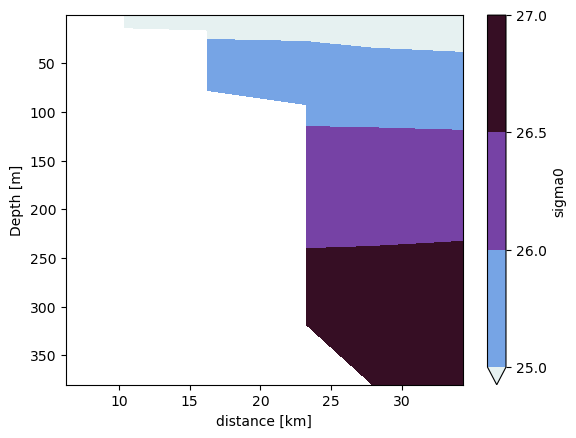

In [44]:
(sigma0_TS_line).mean("time").sel(distance = slice(5, 40), depth = slice(0, 400)).plot.contourf(cmap = cm.dense, levels = [25.0, 26.0, 26.5, 27])
plt.gca().invert_yaxis()

In [49]:
z = -salinity_TS.depth
SP = salinity_TS
pt0 = theta_TS
sigma0_TS = sigma0_from_SP_and_pt0(z, SP, pt0)
sigma0_TS = sigma0_TS.rename("sigma0")

### Get NINO 3.4 Index

In [32]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1993", None))

/tmp/ipykernel_174210/1256711081.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  NINO34_ds = xr.DataArray(


### Get monthly anomalies from each dset 

In [52]:
theta_anom = remove_daily_climatology(theta_TS) #pot. temp anomaly
salinity_anom = remove_daily_climatology(salinity_TS) #salinity anomaly
sigma0_anom = remove_daily_climatology(sigma0_TS) #salinity anomaly
sigma0_TS_anom = remove_daily_climatology(sigma0_TS_line) #salinity anomaly

### Zoom in on 1996 El Nino 

In [69]:
def plot_contourf_ts(ds, time_slice, levels, ax, cmap):
    var_crop = ds.sel(dict(time = time_slice, depth = slice(0, 100))).transpose() #crop
    T, D = np.meshgrid(var_crop.time.values, var_crop.depth.values)
    ax.contourf(T, D, var_crop.values, cmap = cmap, levels = levels)
    CS = ax.contour(T, D, var_crop.values, colors = "k",  levels = levels, extend = "both")
    ax.clabel(CS, inline=True, fontsize=12.5, inline_spacing = 25)

    
def plot_contourf_ts_anomalis(ds, time_slice, ax, cmap, spacing = 7):
    var_crop = ds.sel(dict(time = time_slice, depth = slice(0, 100))).transpose() #crop
    T, D = np.meshgrid(var_crop.time.values, var_crop.depth.values)
    bounds = np.round(np.abs(np.max(var_crop)), decimals = 1);
    levels = np.linspace(-bounds, bounds, spacing)
    print(levels)
    c = ax.contourf(T, D, var_crop.values, vmin = -bounds, vmax = bounds, cmap = cmap, levels = levels, extend = "both")
    return c

def plot_pcolor_ts_anomalis(ds, time_slice, ax, cmap):
    var_crop = ds.sel(dict(time = time_slice, depth = slice(0, 100))).transpose() #crop
    T, D = np.meshgrid(var_crop.time.values, var_crop.depth.values)
    bounds = np.round(np.abs(np.min(var_crop)), decimals = 1);
    c = ax.pcolormesh(T, D, var_crop.values, vmin = -bounds, vmax = bounds, cmap = cmap, shading = "gourad")
    return c


/tmp/ipykernel_174210/826963464.py:22: UserWarning: shading value 'gourad' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  c = ax.pcolormesh(T, D, var_crop.values, vmin = -bounds, vmax = bounds, cmap = cmap, shading = "gourad")
/tmp/ipykernel_174210/826963464.py:22: UserWarning: shading value 'gourad' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  c = ax.pcolormesh(T, D, var_crop.values, vmin = -bounds, vmax = bounds, cmap = cmap, shading = "gourad")
/tmp/ipykernel_174210/826963464.py:22: UserWarning: shading value 'gourad' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  c = ax.pcolormesh(T, D, var_crop.values, vmin = -bounds, vmax = bounds, cmap = cmap, shading = "gourad")


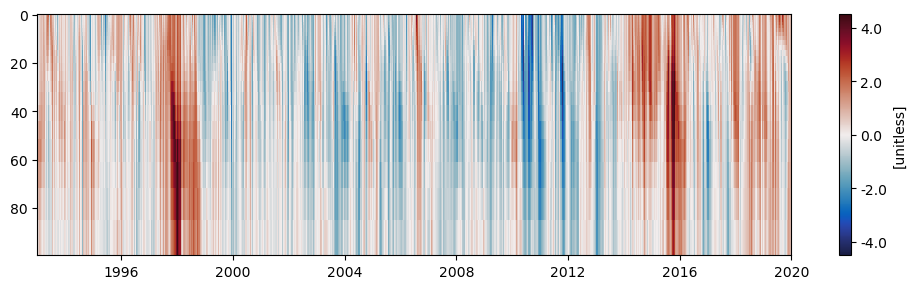

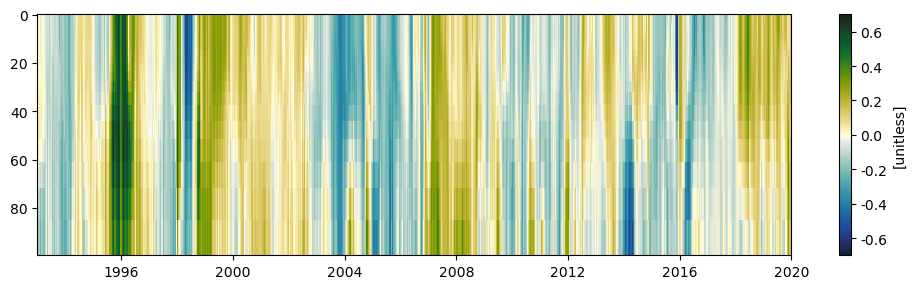

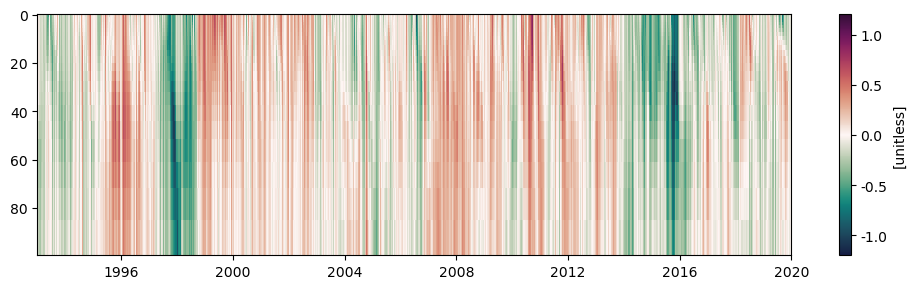

In [79]:
time_slice= slice("1993", "2019")

fig, axes = plt.subplots(figsize = (10,3), sharex = True)
cf = plot_pcolor_ts_anomalis(theta_anom, time_slice, ax = axes, cmap = cm.balance)
fig.colorbar(cf, label = "[unitless]", ax = axes, format='%.1f')

axes.set_xlabel("")
axes.invert_yaxis()
fig.tight_layout();


fig, axes = plt.subplots(figsize = (10,3), sharex = True)
cf = plot_pcolor_ts_anomalis(salinity_anom, time_slice, ax = axes, cmap = cm.delta)
fig.colorbar(cf, label = "[unitless]", ax = axes, format='%.1f')

axes.set_xlabel("")
axes.invert_yaxis()

fig.tight_layout();


fig, axes = plt.subplots(figsize = (10, 3), sharex = True)
cf = plot_pcolor_ts_anomalis(sigma0_anom, time_slice, ax = axes, cmap = cm.curl)
fig.colorbar(cf, label = "[unitless]", ax = axes, format='%.1f')

axes.set_xlabel("")
axes.invert_yaxis()
fig.tight_layout();

# fig.savefig("TempAnom_97.png", dpi = 400)

[-5.6        -3.73333333 -1.86666667  0.          1.86666667  3.73333333
  5.6       ]
[-0.5        -0.33333333 -0.16666667  0.          0.16666667  0.33333333
  0.5       ]
[-0.6 -0.4 -0.2  0.   0.2  0.4  0.6]


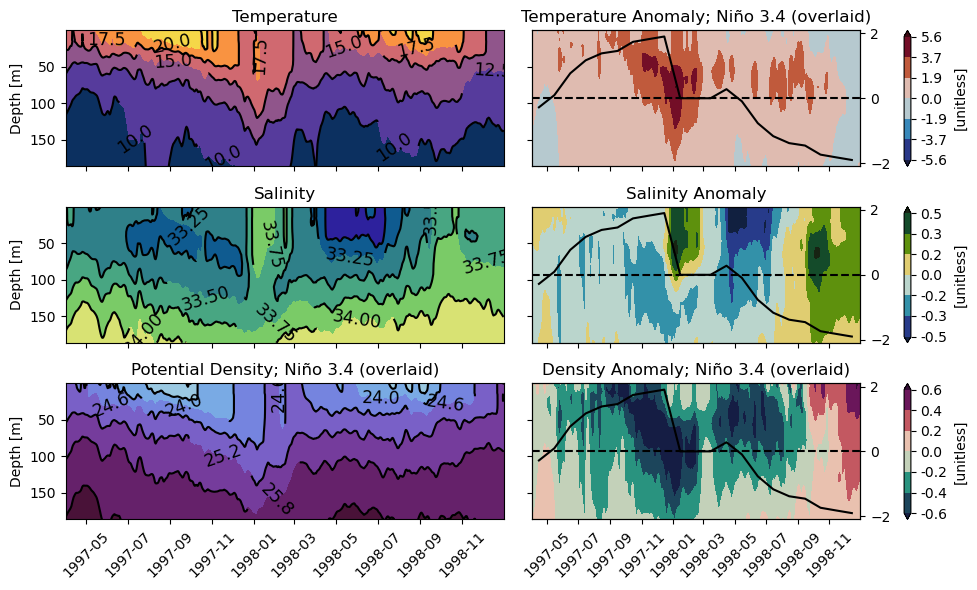

In [55]:
time_slice= slice("1997.4", "1998.")
fig, axes_b = plt.subplots(3,2, figsize = (10, 6), sharex = 'col', sharey = 'row')
axes = axes_b.flatten()

plot_contourf_ts(theta_TS, time_slice, levels = 5, ax = axes[0], cmap = cm.thermal)
axes[0].set_title("Temperature")
axes[0].set_ylabel("Depth [m]")

cf = plot_contourf_ts_anomalis(theta_anom, time_slice, ax = axes[1], cmap = cm.balance)
fig.colorbar(cf, label = "[unitless]", ax = axes[1], format='%.1f', pad = 0.1)
axes[1].set_title("Temperature Anomaly; Niño 3.4 (overlaid)")
axes[1].invert_yaxis()

ax2=axes[1].twinx()
ax2.hlines(0, axes[1].get_xlim()[0], axes[1].get_xlim()[1], linestyle = "--", color = "k")
remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = ax2, color = "k")
# ax2.set_ylabel("NINO3.4",color="black")

plot_contourf_ts(salinity_TS, time_slice, levels = 5, ax = axes[2], cmap = cm.haline)
axes[2].set_title("Salinity")
axes[2].set_ylabel("Depth [m]")

cf = plot_contourf_ts_anomalis(salinity_anom, time_slice, ax = axes[3], cmap = cm.delta)
fig.colorbar(cf, label = "[unitless]", ax = axes[3], format='%.1f', pad = 0.1)

axes[3].set_title("Salinity Anomaly")
axes[3].invert_yaxis()
ax2=axes[3].twinx()
ax2.hlines(0, axes[1].get_xlim()[0], axes[1].get_xlim()[1], linestyle = "--", color = "k")
remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = ax2, color = "k")

plot_contourf_ts(sigma0_TS, time_slice, levels = 6, ax = axes[4], cmap = cm.dense)
axes[4].set_title("Potential Density; Niño 3.4 (overlaid)")
axes[4].set_ylabel("Depth [m]")

cf = plot_contourf_ts_anomalis(sigma0_anom, time_slice, ax = axes[5], cmap = cm.curl)
fig.colorbar(cf, label = "[unitless]", ax = axes[5], format='%.1f', pad = 0.1)
ax2=axes[5].twinx()
ax2.hlines(0, axes[1].get_xlim()[0], axes[1].get_xlim()[1], linestyle = "--", color = "k")
remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = ax2, color = "k")

axes[5].set_title("Density Anomaly; Niño 3.4 (overlaid)")
axes[5].invert_yaxis()

[ax.xaxis.set_tick_params(rotation=45) for ax in axes[4:]]
fig.tight_layout()


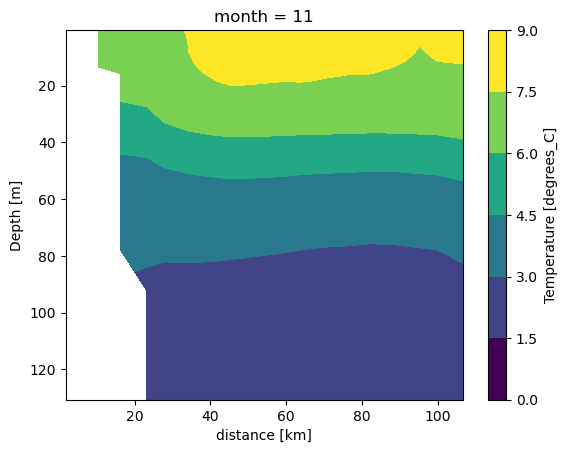

In [106]:
sigma0_TS_line.groupby("time.month").mean("time").sel(month = 11).sel(depth = slice(0, 150)).plot.contourf(vmin = 0, vmax = 9)
plt.gca().invert_yaxis()

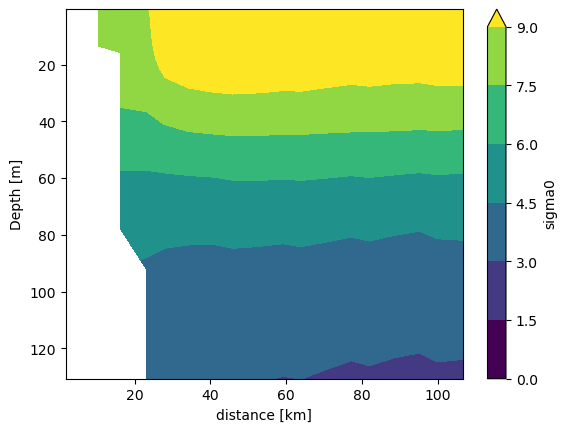

In [98]:
sigma0_TS_line.sel(time = slice("2015.9", "2015.99")).mean("time").sel(depth = slice(0, 150)).plot.contourf(vmin = 0, vmax = 9)
plt.gca().invert_yaxis()

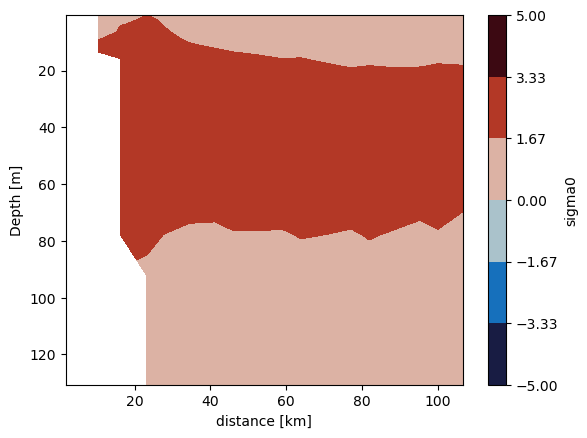

In [107]:
sigma0_TS_anom.sel(time = slice("2015.9", "2015.99")).mean("time").sel(depth = slice(0, 150)).plot.contourf(vmin = -5, vmax = 5, cmap = cm.balance)
plt.gca().invert_yaxis()

[-4.9        -3.26666667 -1.63333333  0.          1.63333333  3.26666667
  4.9       ]
[-0.4        -0.26666667 -0.13333333  0.          0.13333333  0.26666667
  0.4       ]
[-0.6 -0.4 -0.2  0.   0.2  0.4  0.6]
[-1.7        -1.13333333 -0.56666667  0.          0.56666667  1.13333333
  1.7       ]
[-0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
[-0.5        -0.33333333 -0.16666667  0.          0.16666667  0.33333333
  0.5       ]
[-3.6000000e+00 -2.4000000e+00 -1.2000000e+00 -4.4408921e-16
  1.2000000e+00  2.4000000e+00  3.6000000e+00]
[-0.4        -0.26666667 -0.13333333  0.          0.13333333  0.26666667
  0.4       ]
[-0.5        -0.33333333 -0.16666667  0.          0.16666667  0.33333333
  0.5       ]
[-2.1 -1.4 -0.7  0.   0.7  1.4  2.1]
[-0.4        -0.26666667 -0.13333333  0.          0.13333333  0.26666667
  0.4       ]
[-0.8        -0.53333333 -0.26666667  0.          0.26666667  0.53333333
  0.8       ]
[-4.8 -3.2 -1.6  0.   1.6  3.2  4.8]
[-0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
[-0.3 -0.2 

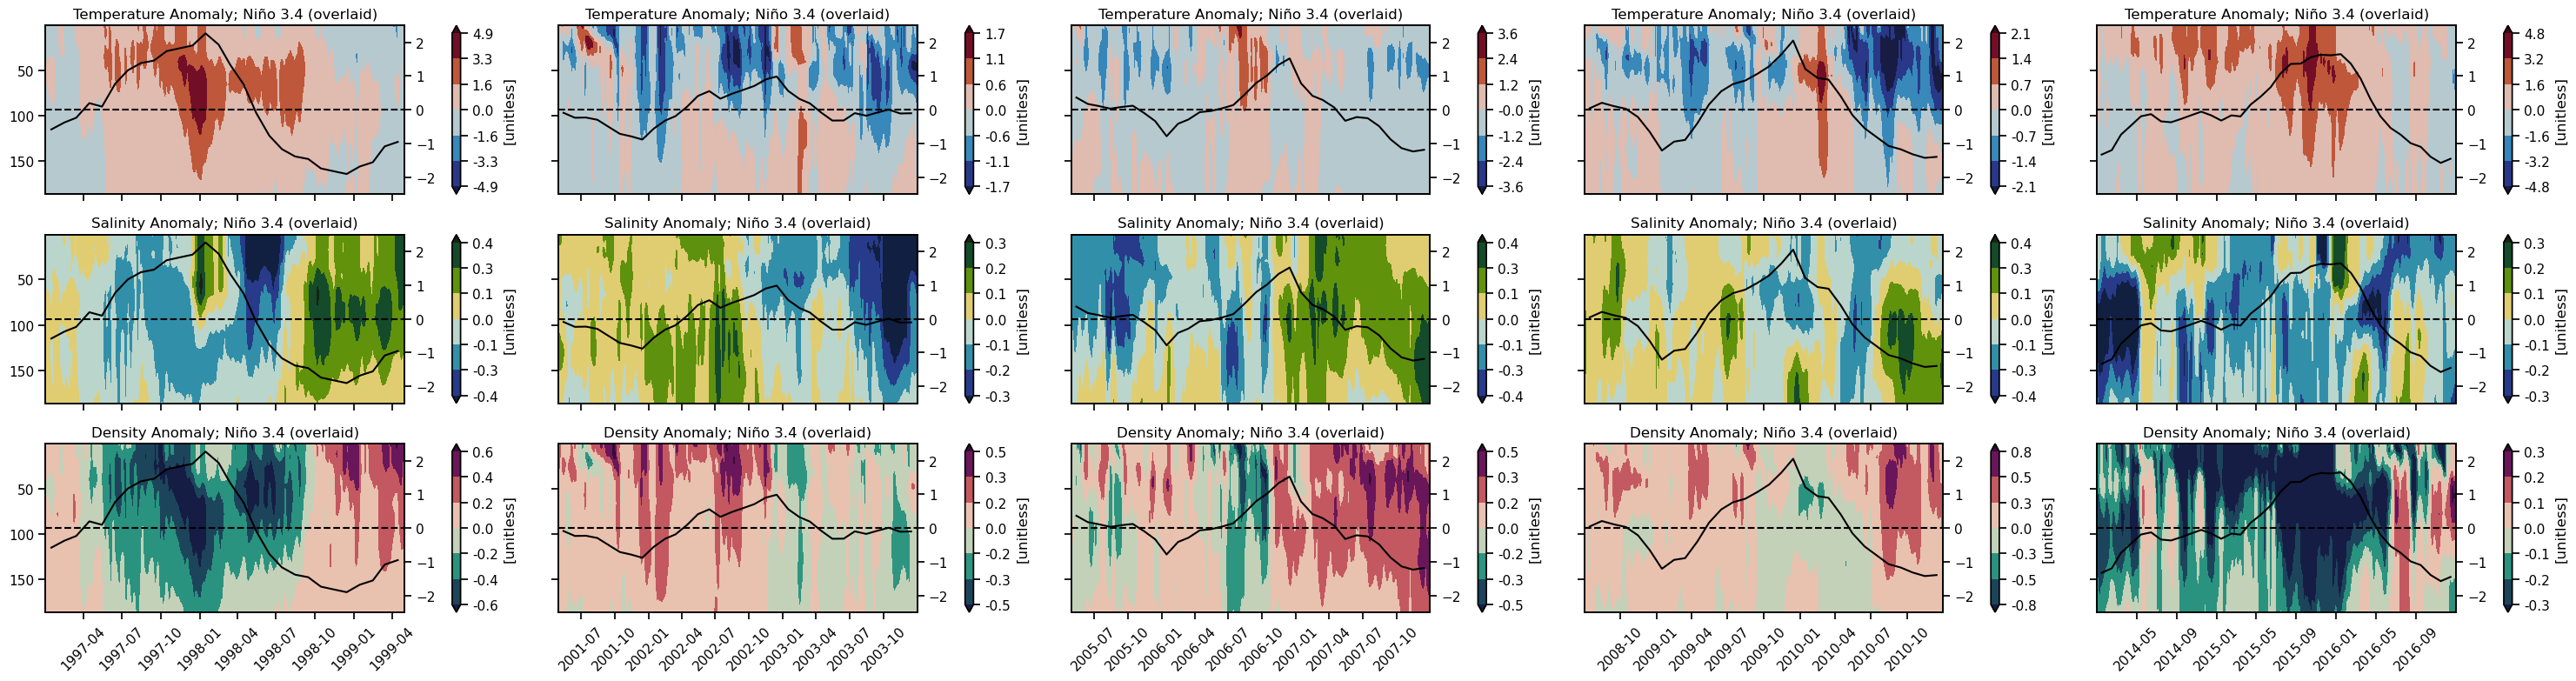

In [58]:
time_slices= [slice("1997", "1999.4"), slice("2001.5", "2003"),
              slice("2005.5", "2007"), slice("2008.7", "2010"),
              slice("2014", "2016")]
fig, axes_b = plt.subplots(3,5, figsize = (30, 8), sharex = 'col', sharey = 'row')

for (i, time_slice) in enumerate(time_slices):
    axes = axes_b[:, i].flatten()

    cf = plot_contourf_ts_anomalis(theta_anom, time_slice, ax = axes[0], cmap = cm.balance)
    fig.colorbar(cf, label = "[unitless]", ax = axes[0], format='%.1f', pad = 0.1)
    axes[0].set_title("Temperature Anomaly; Niño 3.4 (overlaid)")
    axes[0].invert_yaxis()

    ax2=axes[0].twinx()
    ax2.hlines(0, axes[0].get_xlim()[0], axes[0].get_xlim()[1], linestyle = "--", color = "k")
    remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = ax2, color = "k")
    # ax2.set_ylabel("NINO3.4",color="black")
    ax2.set_ylim(-2.5, 2.5)



    cf = plot_contourf_ts_anomalis(salinity_anom, time_slice, ax = axes[1], cmap = cm.delta)
    fig.colorbar(cf, label = "[unitless]", ax = axes[1], format='%.1f', pad = 0.1)
    axes[1].set_title("Salinity Anomaly; Niño 3.4 (overlaid)")
    axes[1].invert_yaxis()

    ax2=axes[1].twinx()
    ax2.hlines(0, axes[0].get_xlim()[0], axes[0].get_xlim()[1], linestyle = "--", color = "k")
    remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = ax2, color = "k")
    ax2.set_ylim(-2.5, 2.5)


    cf = plot_contourf_ts_anomalis(sigma0_anom, time_slice, ax = axes[2], cmap = cm.curl)
    fig.colorbar(cf, label = "[unitless]", ax = axes[2], format='%.1f', pad = 0.1)
    axes[2].set_title("Density Anomaly; Niño 3.4 (overlaid)")
    axes[2].invert_yaxis()

    ax2=axes[2].twinx()
    ax2.hlines(0, axes[0].get_xlim()[0], axes[0].get_xlim()[1], linestyle = "--", color = "k")
    remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = ax2, color = "k")
    ax2.set_ylim(-2.5, 2.5)



[ax.xaxis.set_tick_params(rotation=45) for ax in axes_b[-1, :]]
fig.tight_layout()
# fig.savefig("Line90Anomalies200km.png", dpi = 1000)

[-4.9        -3.26666667 -1.63333333  0.          1.63333333  3.26666667
  4.9       ]
[-0.4        -0.26666667 -0.13333333  0.          0.13333333  0.26666667
  0.4       ]
[-0.6 -0.4 -0.2  0.   0.2  0.4  0.6]
[-4.8 -3.2 -1.6  0.   1.6  3.2  4.8]
[-0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
[-0.3 -0.2 -0.1  0.   0.1  0.2  0.3]


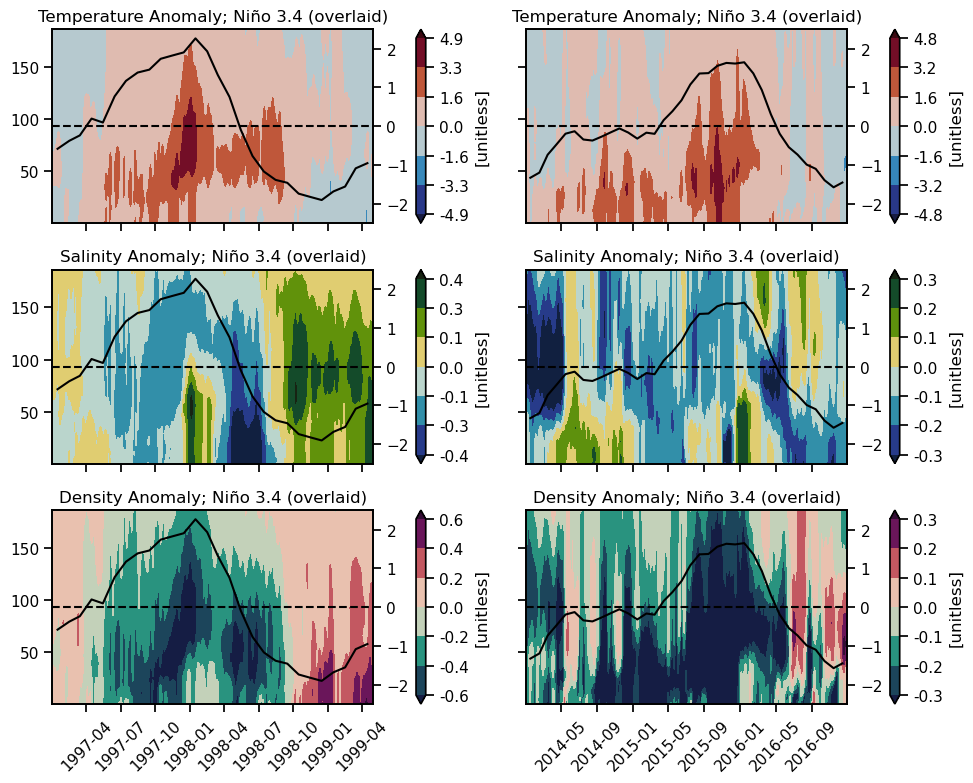

In [59]:
time_slices= [slice("1997", "1999.4"),
              slice("2014", "2016")]
fig, axes_b = plt.subplots(3,2, figsize = (10, 8), sharex = 'col', sharey = 'row')

for (i, time_slice) in enumerate(time_slices):
    axes = axes_b[:, i].flatten()

    cf = plot_contourf_ts_anomalis(theta_anom, time_slice, ax = axes[0], cmap = cm.balance)
    fig.colorbar(cf, label = "[unitless]", ax = axes[0], format='%.1f', pad = 0.1)
    axes[0].set_title("Temperature Anomaly; Niño 3.4 (overlaid)")
    axes[0].invert_yaxis()

    ax2=axes[0].twinx()
    ax2.hlines(0, axes[0].get_xlim()[0], axes[0].get_xlim()[1], linestyle = "--", color = "k")
    remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = ax2, color = "k")
    # ax2.set_ylabel("NINO3.4",color="black")
    ax2.set_ylim(-2.5, 2.5)



    cf = plot_contourf_ts_anomalis(salinity_anom, time_slice, ax = axes[1], cmap = cm.delta)
    fig.colorbar(cf, label = "[unitless]", ax = axes[1], format='%.1f', pad = 0.1)
    axes[1].set_title("Salinity Anomaly; Niño 3.4 (overlaid)")
    axes[1].invert_yaxis()

    ax2=axes[1].twinx()
    ax2.hlines(0, axes[0].get_xlim()[0], axes[0].get_xlim()[1], linestyle = "--", color = "k")
    remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = ax2, color = "k")
    ax2.set_ylim(-2.5, 2.5)


    cf = plot_contourf_ts_anomalis(sigma0_anom, time_slice, ax = axes[2], cmap = cm.curl)
    fig.colorbar(cf, label = "[unitless]", ax = axes[2], format='%.1f', pad = 0.1)
    axes[2].set_title("Density Anomaly; Niño 3.4 (overlaid)")
    axes[2].invert_yaxis()

    ax2=axes[2].twinx()
    ax2.hlines(0, axes[0].get_xlim()[0], axes[0].get_xlim()[1], linestyle = "--", color = "k")
    remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = ax2, color = "k")
    ax2.set_ylim(-2.5, 2.5)



[ax.xaxis.set_tick_params(rotation=45) for ax in axes_b[-1, :]]
fig.tight_layout()
# fig.savefig("Line90Anomalies200km.png", dpi = 1000)

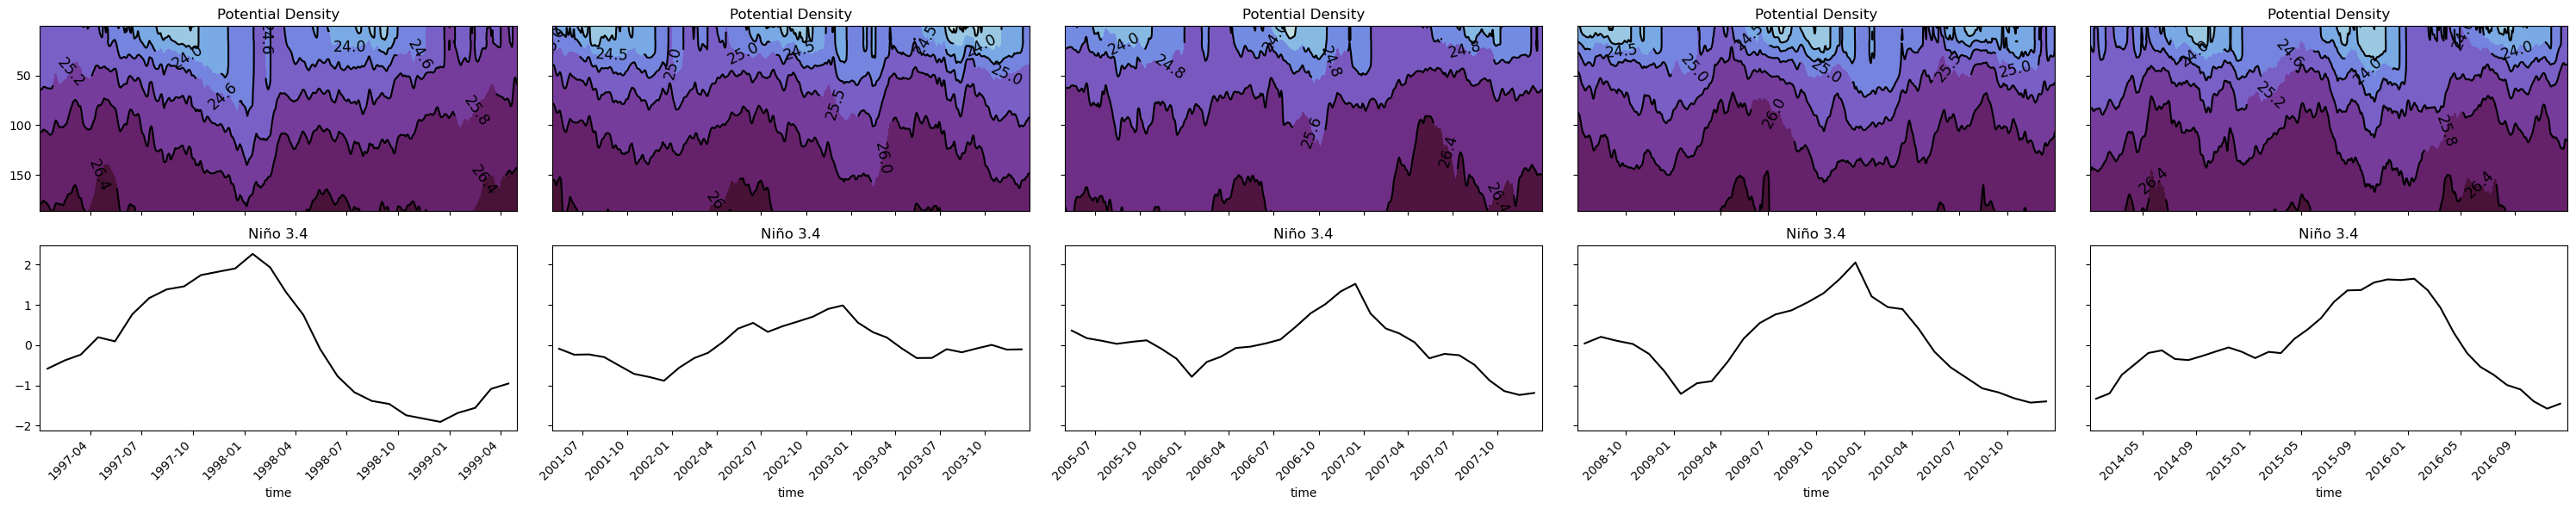

In [45]:
time_slices= [slice("1997", "1999.4"), slice("2001.5", "2003"),
              slice("2005.5", "2007"), slice("2008.7", "2010"),
              slice("2014", "2016")]
fig, axes_b = plt.subplots(2,5, figsize = (30, 6), sharex = 'col', sharey = 'row')

for (i, time_slice) in enumerate(time_slices):
    axes = axes_b[0, :].flatten()
    axes2 = axes_b[1, :].flatten()

    plot_contourf_ts(sigma0_TS, time_slice, levels = 6, ax = axes[i], cmap = cm.dense)

    axes[i].set_title("Potential Density")
    ax2.hlines(0, axes[0].get_xlim()[0], axes[0].get_xlim()[1], linestyle = "--", color = "k")
    remove_seasonal(NINO34.sel(dict(time = time_slice))).plot(ax = axes2[i], color = "k")
    axes2[i].set_title("Niño 3.4")

axes[0].invert_yaxis()
[ax.xaxis.set_tick_params(rotation=45) for ax in axes_b[1, :]]
fig.tight_layout()
fig.savefig("Line90Densities200km.png", dpi = 400)

## Acquire the de-seasoned ERA5 Water Vapour 

### Do some re-gridding and daily averaging

In [61]:
def read_ds_atm(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds.sel(longitude = slice(-121, -114), latitude = slice(35, 30))

        return ds_new

In [62]:
%%time 
n_cores = multiprocessing.cpu_count() - 5
file_path = "ERA5_data"
ERA5_results = natsorted([str(result) for result in list(Path(file_path).rglob("*.[nN][cC]"))])[:-1]

NINO_97_ERA5 = []
    
files = natsorted([str(f) for f in ERA5_results])

if __name__ == '__main__':
    with Pool(n_cores) as p:
        datasets = p.map(read_ds_atm, files)
NINO_97_ERA5 = NINO_97_ERA5 + datasets #about 50 gigs of data!! 

#read in data 
NINO_97_ERA5_ds = xr.concat(NINO_97_ERA5, dim = "time", data_vars = "minimal", coords = "minimal")
NINO_97_ERA5_ds = NINO_97_ERA5_ds.sortby("time")

CPU times: user 1.72 s, sys: 2.68 s, total: 4.4 s
Wall time: 17.2 s


In [248]:
#resample to daily 
ERA5_ds = NINO_97_ERA5_ds.resample(time="1D").mean() #resample from 1 hr to 1 day
ERA5_ds = ERA5_ds.rolling(time=21, center=True).mean() #14-day rolling average
# ERA5M_ds = NINO_97_ERA5_ds.resample(time="1M").mean()

In [249]:
#total precipitation over the region (units may be wrong) 
tp = 1e3 * (24 * ERA5_ds.tp.mean(dim = ["latitude", "longitude"]))# m water /hour to mm /day
tp_anom = remove_seasonal(tp)
# tpM = ERA5M_ds.tp.mean(dim = ["latitude", "longitude"])
# tp_anom = remove_seasonal(tp)

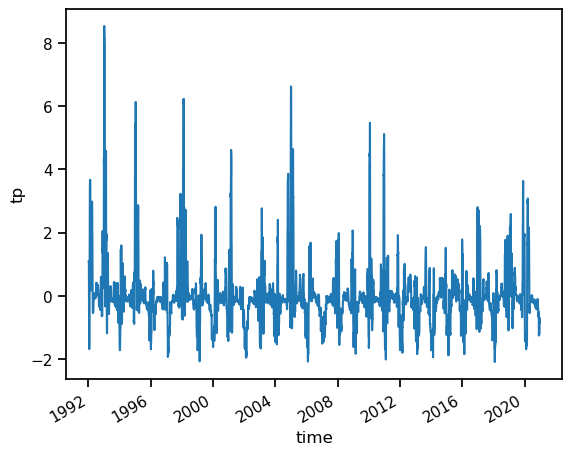

In [250]:
tp_anom_rolling = normalize(tp_anom)
tp_anom_rolling.plot()
# tp_anom.plot(figsize = (12.5, 7.5))
# tp_anom_rolling = tp_anom.rolling(time=4, center=True).mean()

[-4.9        -3.26666667 -1.63333333  0.          1.63333333  3.26666667
  4.9       ]
[-1.7        -1.13333333 -0.56666667  0.          0.56666667  1.13333333
  1.7       ]
[-3.6000000e+00 -2.4000000e+00 -1.2000000e+00 -4.4408921e-16
  1.2000000e+00  2.4000000e+00  3.6000000e+00]
[-2.1 -1.4 -0.7  0.   0.7  1.4  2.1]
[-4.8 -3.2 -1.6  0.   1.6  3.2  4.8]


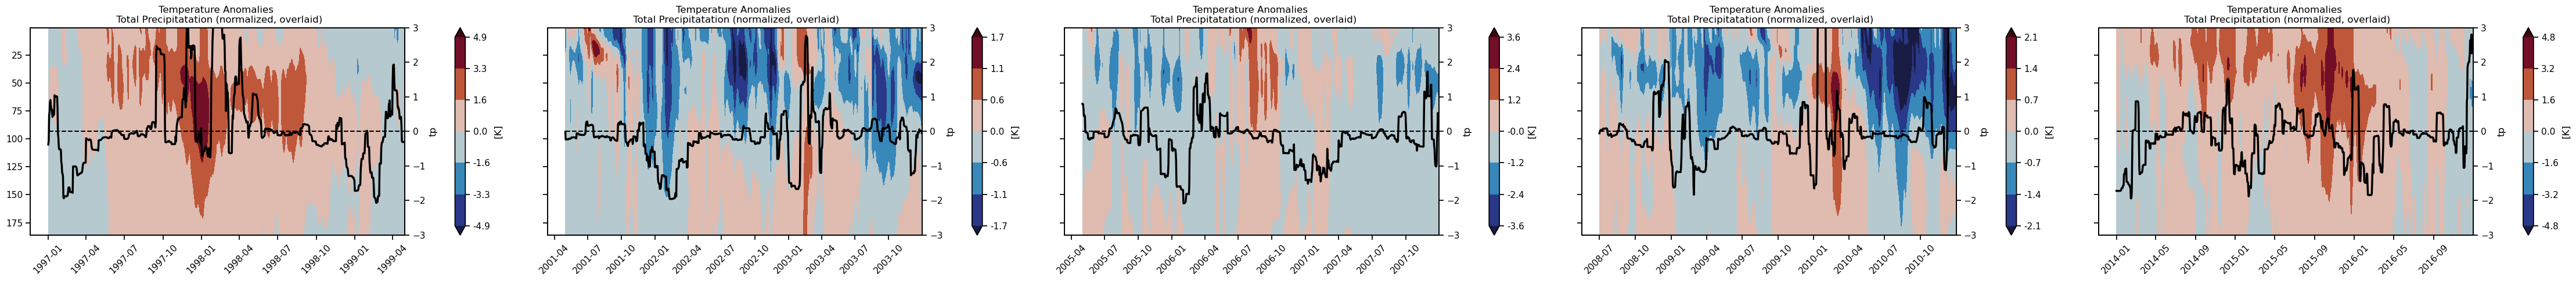

In [263]:
time_slices= [slice("1997", "1999.4"), slice("2001.5", "2003"),
              slice("2005.5", "2007"), slice("2008.7", "2010"),
              slice("2014", "2016")]
fig, axes = plt.subplots(1,5, figsize = (45, 5), sharex = 'col', sharey = 'row')

for (i, time_slice) in enumerate(time_slices):

    cf = plot_contourf_ts_anomalis(theta_anom, time_slice, ax = axes[i], cmap = cm.balance)
    fig.colorbar(cf, label = "[K]", ax = axes[i], format='%.1f', pad = 0.1)
    axes[i].set_title("Temperature Anomalies \n Total Precipitatation (normalized, overlaid)")
    axes[i].invert_yaxis()

    ax2=axes[i].twinx()
    xlim0, xlim1 = axes[i].get_xlim()
    ax2.hlines(0, xlim0, xlim1, linestyle = "--", color = "k")
    tp_anom_rolling.sel(dict(time = time_slice)).plot(ax = ax2, color = "k", linewidth = 2.5)
    # ax2.set_ylabel("NINO3.4",color="black")
    ax2.set_ylim(-3, 3)



[ax.xaxis.set_tick_params(rotation=45) for ax in axes]
fig.tight_layout()
fig.savefig("Line90AnomalieswTP200km.pdf")

/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


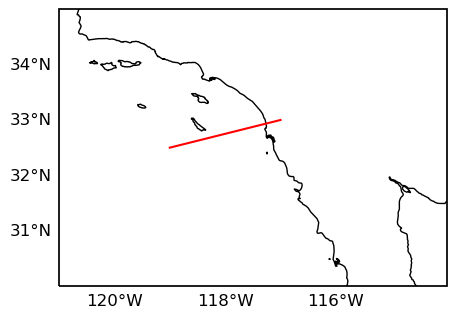

In [256]:
fig,ax1 = plt.subplots(figsize = (5, 5),  subplot_kw = {"projection":ccrs.PlateCarree()})
LONS, LATS = np.meshgrid(NINO_97_ERA5_ds.longitude, NINO_97_ERA5_ds.latitude)
cf = ax1.contourf(LONS, LATS, np.nan*NINO_97_ERA5_ds.tp[4, :, :],
                  cmap=cm.curl, extend = "both")
ax1.plot(xs_C, ys_C, color = "red"); 

ax1.coastlines(color= "black")
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
gl.xlabels_top = False
gl.ylabels_right = False

In [173]:
#construct monthly climatology
ERA5_ds_climatology = read_ds_atm("ERA5_data/ERA5_monthly.nc")
ERA5_ds_climatology = ERA5_ds_climatology.groupby("time.month").mean("time")
anomalies = NINO_97_ERA5_ds.groupby("time.month") - ERA5_ds_climatology
NINO_97_ERA5_ds_anom = anomalies.tcwv.drop("month")

In [173]:
#resampling to daily 
t_dim, r_dim, c_dim =NINO_97_ERA5_ds_anom.shape
t_dim, r_dim, c_dim

(1461, 37, 53)

Text(0, 0.5, '%')

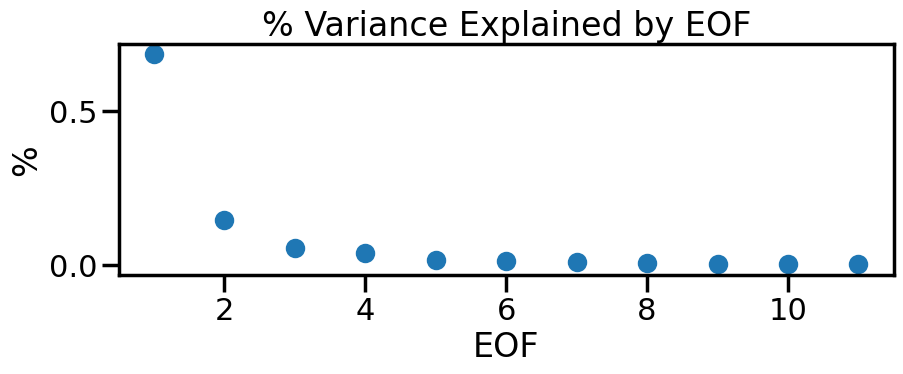

In [175]:
Y, SVD_mat, theta_mean, not_wet = do_EOF_on_xarray(NINO_97_ERA5_ds_anom.values)
u, s, vh = SVD_mat
perc_var = ([lam**2 / np.sum(s**2) for lam in s[0:11]])
fig,axes = plt.subplots( figsize = (10, 3))
axes.scatter(range(1, len(perc_var)+1), perc_var)
axes.set_title("% Variance Explained by EOF")
axes.set_xlabel("EOF")
axes.set_ylabel("%")

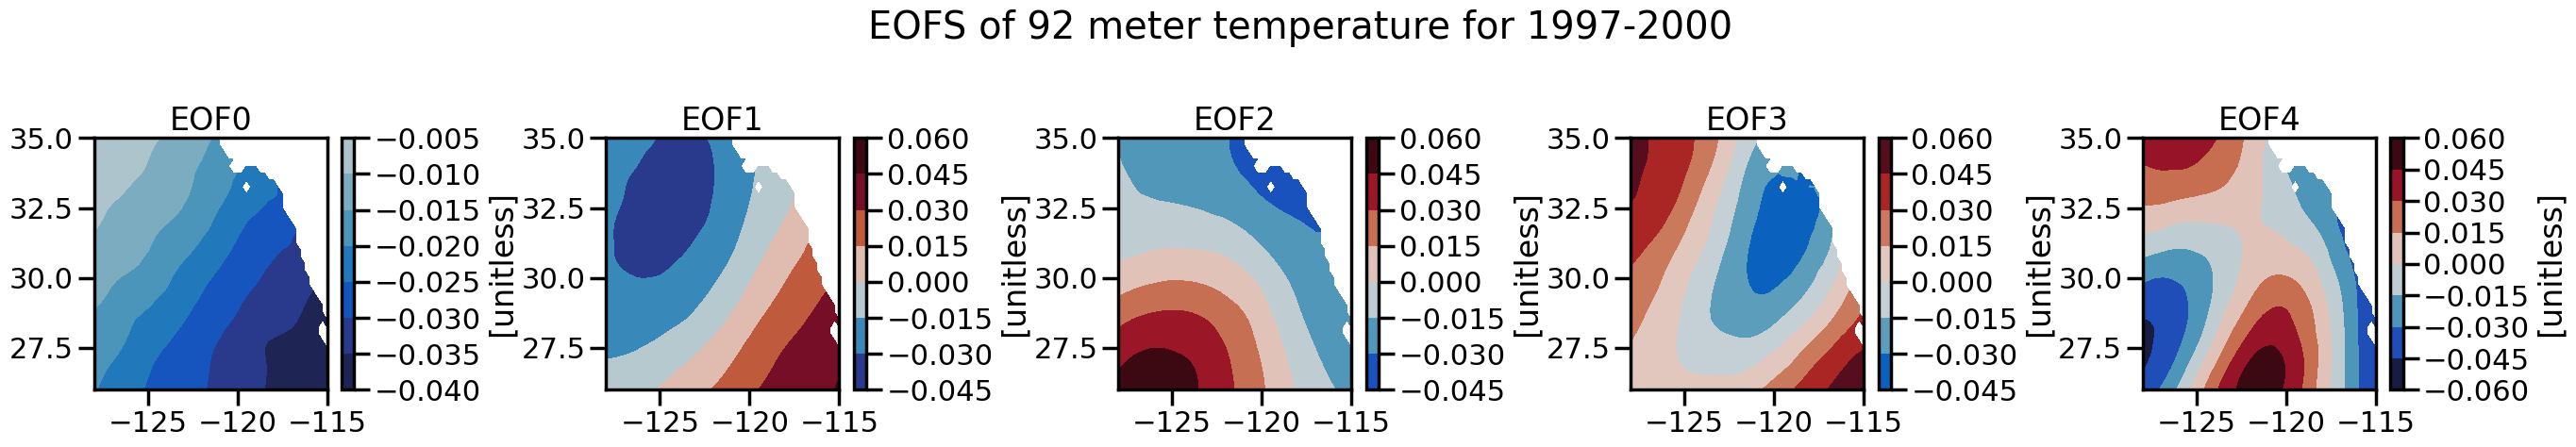

In [ ]:
import cmocean
cmap = cmocean.cm.balance

neofs = 5
fig,axes = plt.subplots(ncols= neofs, figsize = (27.5, 5))
LONS, LATS = np.meshgrid(NINO_97_ERA5_ds_anom.longitude, NINO_97_ERA5_ds_anom.latitude)
ax = axes.flatten()
for i in range(0, neofs):
    
    EOF = np.copy(u[:, i:i+1])
    EOF[not_wet] = np.nan
    EOF = np.reshape(EOF, (r_dim, c_dim))


    bounds = np.nanmax(np.abs(EOF))
    cf = ax[i].contourf(LONS, LATS, EOF, cmap = cmap, vmin = -bounds, vmax = bounds)
    cbar = fig.colorbar(cf, label = "[unitless]", ax = ax[i])
    ax[i].set_title("EOF" + str(i))

fig.suptitle("EOFS of 92 meter temperature for 1997-2000")
fig.tight_layout()